# Chest X-ray of Pneumonia

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as mpt
import os
import seaborn as sns
import tensorflow as ts

# Packages for data processing
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# Packages for deep learning model
from keras import Input, Model
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, Activation, Dropout, MaxPooling2D, Flatten, Dense, Add

# Packages for visualization of results
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, PrecisionRecallDisplay, precision_recall_curve
import shap

## Pre-processing

### Data Visualization

NORMAL2-IM-1294-0001-0002.jpeg


(1260, 1400)

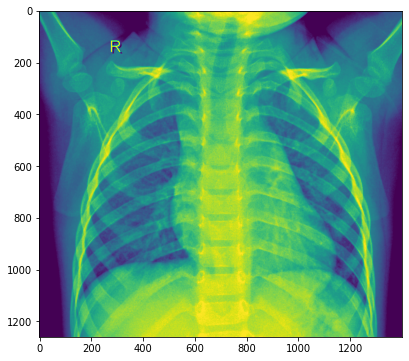

In [2]:
# images visualisation
print(os.listdir('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/')[1]) # Show image name
train_norm_path = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
norm_im = mpt.imread(f'{train_norm_path}{os.listdir(train_norm_path)[1]}')
f = mpt.figure(figsize= (10,6))
img_plot = mpt.imshow(norm_im) # Show image
norm_im.shape # Show image size

### Loading the Dataset

In [3]:
# Path
train_dir = r'../input/chest-xray-pneumonia/chest_xray/train/'
test_dir = r'../input/chest-xray-pneumonia/chest_xray/test/'
val_dir = r'../input/chest-xray-pneumonia/chest_xray/val/'

In [4]:
# Set parameters for generate new data

# With split
split_gen = ImageDataGenerator(rescale=1./255,
                               zoom_range=0.2, 
                               shear_range=0.2,
                               horizontal_flip=True,
                               validation_split=0.2)
# Without split
image_gen = ImageDataGenerator(rescale=1./255,
                               zoom_range=0.2, 
                               shear_range=0.2,
                               horizontal_flip=True)


In [5]:
# Loading the 3 Datasets
train_set = image_gen.flow_from_directory(batch_size = 32, directory=train_dir, target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')
test_set = image_gen.flow_from_directory(batch_size = 624, directory=test_dir, target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')
val_set = image_gen.flow_from_directory(batch_size = 32, directory=val_dir, target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


The validation dataset is too small, we need to split the train dataset in order to constitute a better dataset of the validation

In [6]:
#Loading data with the split
train_set = split_gen.flow_from_directory(batch_size = 32, directory=train_dir, subset = "training", target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')
val_set = split_gen.flow_from_directory(batch_size = 32, directory=train_dir, subset = "validation", target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [7]:
print(f"Number of data in train_set : {np.bincount(train_set.classes)}")

print(f"Number of data in val_set : {np.bincount(val_set.classes)}")

Number of data in train_set : [1073 3100]
Number of data in val_set : [268 775]


[1073 3100]


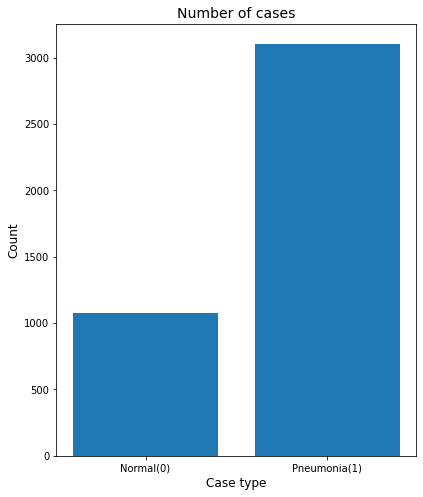

In [8]:
cases_count = np.bincount(train_set.classes)
print(cases_count)

# Plot the results 
fig = mpt.figure(figsize=(5,6))
ax = fig.add_axes([0,0,1,1])
img = train_set.class_indices.keys()
ax.bar(img, cases_count)
mpt.title('Number of cases', fontsize=14)
mpt.xlabel('Case type', fontsize=12)
mpt.ylabel('Count', fontsize=12)
mpt.xticks(range(len(train_set.class_indices)), ['Normal(0)', 'Pneumonia(1)'])
mpt.show()

The number of data for Pneumonia is three time higher than the one for Normal, we need to set weights to equilibrate ours models

In [9]:
# Weight balancing
weight_pneumo = 1
weight_normal = 3
class_weight = {0: weight_normal, 1: weight_pneumo}

## CNN

2022-10-27 14:51:04.118084: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                401472

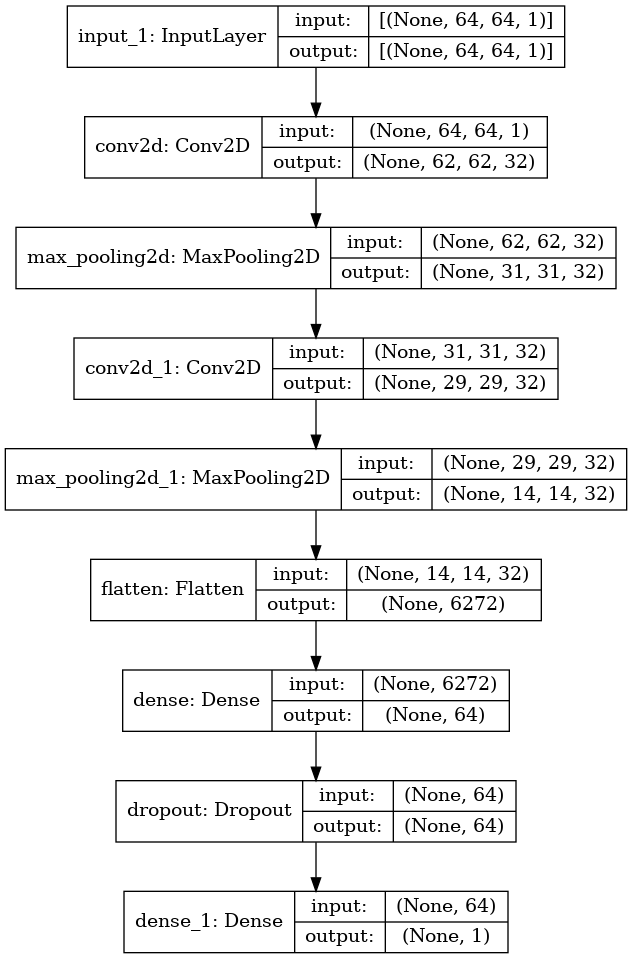

In [10]:
# Create model
def cnn():
  inputs = Input(shape=(64, 64, 1))
  conv_1 = Conv2D(32,(3,3), activation = "relu")(inputs)
  pool_1 = MaxPooling2D(pool_size = (2,2))(conv_1)
  conv_2 = Conv2D(32,(3,3), activation = "relu")(pool_1)
  pool_2 = MaxPooling2D(pool_size = (2,2))(conv_2)
  flat = Flatten()(pool_2)
  dense_1 = Dense(activation = 'relu', units = 64)(flat)
  drop = Dropout(0.2)(dense_1)
  dense_2 = Dense(activation = 'sigmoid', units = 1)(drop)
  model = Model(inputs=inputs, outputs=dense_2)
  return model

model_1 = cnn()
plot_model(model_1,show_shapes=True, show_layer_names=True)
print(model_1.summary())
plot_model(model_1, to_file="model_cnn_pneumo.png",
               show_shapes=True, show_layer_names=True)

In [11]:
# Compile model
model_1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [12]:
# Fit model
model_cnn = model_1.fit(train_set, validation_data = val_set, epochs=10, batch_size=128, class_weight=class_weight)

2022-10-27 14:51:06.126324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
131/131 [==============================] - 89s 676ms/step - loss: 0.6897 - accuracy: 0.7654 - val_loss: 0.2505 - val_accuracy: 0.9022
Epoch 2/10
131/131 [==============================] - 58s 447ms/step - loss: 0.4027 - accuracy: 0.8814 - val_loss: 0.3418 - val_accuracy: 0.8466
Epoch 3/10
131/131 [==============================] - 57s 438ms/step - loss: 0.3799 - accuracy: 0.8914 - val_loss: 0.3133 - val_accuracy: 0.8734
Epoch 4/10
131/131 [==============================] - 58s 440ms/step - loss: 0.3419 - accuracy: 0.9077 - val_loss: 0.2685 - val_accuracy: 0.8878
Epoch 5/10
131/131 [==============================] - 57s 436ms/step - loss: 0.3384 - accuracy: 0.9037 - val_loss: 0.2095 - val_accuracy: 0.9204
Epoch 6/10
131/131 [==============================] - 57s 438ms/step - loss: 0.3348 - accuracy: 0.9080 - val_loss: 0.2203 - val_accuracy: 0.9137
Epoch 7/10
131/131 [==============================] - 58s 439ms/step - loss: 0.2995 - accuracy: 0.9224 - val_loss: 0.1959 - val_ac

In [13]:
# Evaluate model
model_1.evaluate(test_set)

1/1 [==============================] - 6s 6s/step - loss: 0.2843 - accuracy: 0.8686


[0.2842893898487091, 0.8685897588729858]

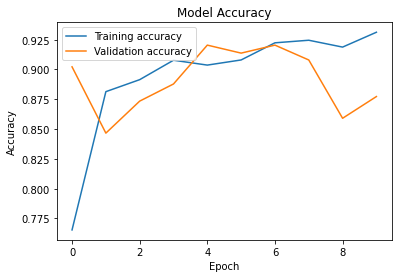

In [14]:
# Plot accuracy 
mpt.plot(model_cnn.history['accuracy'])
mpt.plot(model_cnn.history['val_accuracy'])
mpt.title('Model Accuracy')
mpt.ylabel('Accuracy')
mpt.xlabel('Epoch')
mpt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
mpt.show()

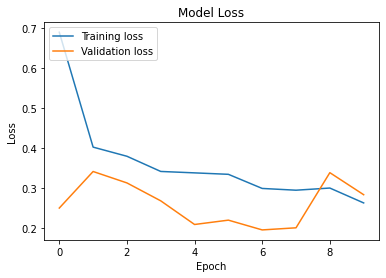

In [15]:
# Plot loss 
mpt.plot(model_cnn.history['loss'])
mpt.plot(model_cnn.history['val_loss'])
mpt.title('Model Loss')
mpt.ylabel('Loss')
mpt.xlabel('Epoch')
mpt.legend(['Training loss', 'Validation loss'], loc='upper left')
mpt.show()

In [16]:
# Split test dataset into x and y
x_test, y_test = next(test_set)

# Predict
y_predict_cnn = model_1.predict(x_test)

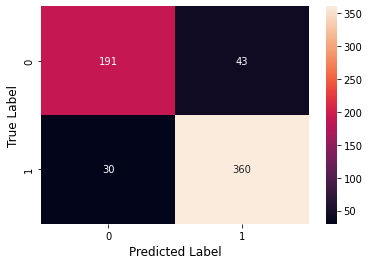

In [17]:
# Plot heatmap
pred_labels_cnn= np.where(y_predict_cnn>0.5, 1, 0)
sns.heatmap(confusion_matrix(y_test, pred_labels_cnn),fmt='g', annot=True)
mpt.xlabel("Predicted Label", fontsize= 12)
mpt.ylabel("True Label", fontsize= 12)

mpt.show()

In [18]:
print(classification_report(y_test, pred_labels_cnn, target_names=test_set.class_indices.keys()))

              precision    recall  f1-score   support

      NORMAL       0.86      0.82      0.84       234
   PNEUMONIA       0.89      0.92      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



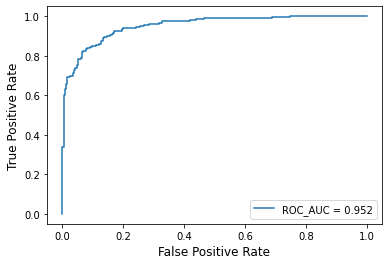

In [19]:
# Plot ROC curve

roc_auc = roc_auc_score(y_test, y_predict_cnn)

fpr, tpr, thresholds = roc_curve(y_test, y_predict_cnn)

mpt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

mpt.xlabel("False Positive Rate", fontsize= 12)
mpt.ylabel("True Positive Rate", fontsize= 12)
mpt.legend(loc="lower right")

mpt.show()

print(classification_report(y_test, pred_labels_cnn, target_names=test_set.class_indices.keys()))## RESNET

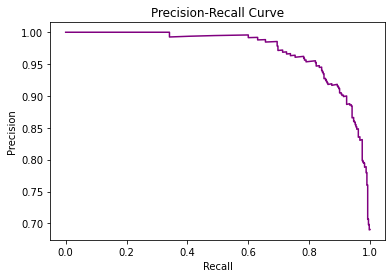

In [20]:
# Plot Precision-Recall curve


#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_predict_cnn)

#create precision recall curve
fig, ax = mpt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
mpt.show()




keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


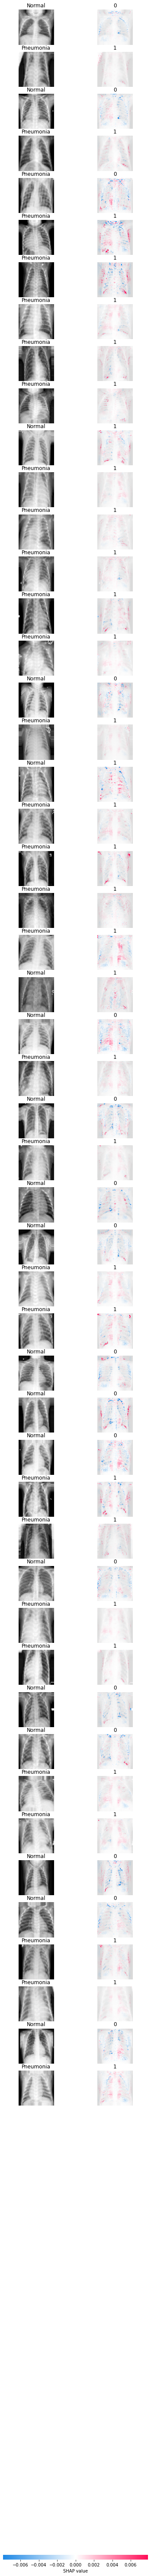

In [21]:
x = shap.DeepExplainer(model_1, x_test)
shap_values = x.shap_values(x_test[:100])
ind_names = list(map(str, y_test))
for i in range(len(ind_names)):
  if ind_names[i] == "0.0" :
    ind_names[i] = 'Normal'
  elif ind_names[i] == "1.0" :
    ind_names[i] = 'Pneumonia'
    
shap.image_plot(shap_values[0][:50], x_test[:50], true_labels = ind_names[:50], labels = pred_labels_cnn[:50])

In [22]:
# Creat ResNet module
def residual_module(lay_i):
    conv_0 = Conv2D(32,(1), padding="same", activation = "relu")(lay_i)
    save = conv_0
    conv_1 = Conv2D(16,(1, 1), padding="same", activation = "relu")(conv_0)
    conv_2 = Conv2D(16,(3, 3), padding="same", activation = "relu")(conv_1)
    conv_3 = Conv2D(32,(1, 1), padding="same", activation = "relu")(conv_2)
    conc_1 = Add()([conv_3, save])
    output = Activation("relu")(conc_1)
    return output

# Create ResNet
def resnet():
    n_residual = 5
    print("Simple residual network with {} modules".format(n_residual))
    inputs = Input(shape=(64, 64, 1))
    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i)


    gavg_1 = MaxPooling2D(pool_size = (2,2))(residual_i)
    flat_1 = Flatten()(gavg_1)
    dense = Dense(32, activation="relu")(flat_1)
    drop = Dropout(0.2)(dense)
    output = Dense(1, activation="sigmoid")(drop)
    model = Model(inputs=inputs, outputs=output)

    return model

Simple residual network with 5 modules
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   64          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 16)   528         conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 16)   2320        conv2d_3[0][0]                   
_____________________________________________________

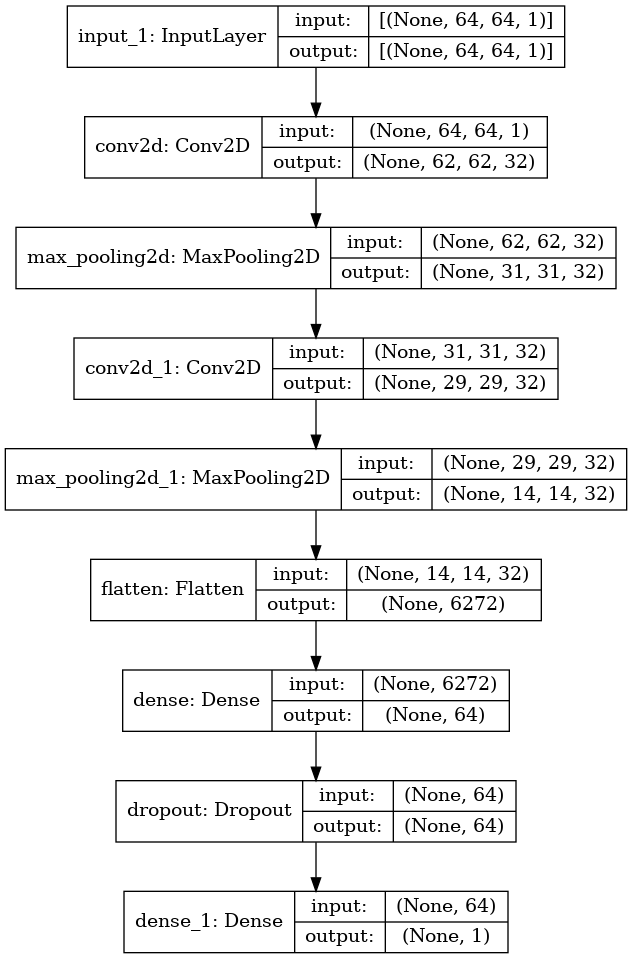

In [23]:
# Plot ResNet model
model_2 = resnet()
plot_model(model_2, to_file="residual.png",
               show_shapes=True, show_layer_names=True)
print(model_2.summary())
plot_model(model_1, to_file="model_cnn_pneumo.png",
               show_shapes=True, show_layer_names=True)

In [24]:
# Compile model
model_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
# Fit model
history_resnet = model_2.fit(train_set, validation_data = val_set, epochs=10, batch_size=128, class_weight=class_weight)

Epoch 1/10
131/131 [==============================] - 85s 637ms/step - loss: 0.7035 - accuracy: 0.7402 - val_loss: 0.4614 - val_accuracy: 0.8178
Epoch 2/10
131/131 [==============================] - 82s 626ms/step - loss: 0.4750 - accuracy: 0.8660 - val_loss: 0.3206 - val_accuracy: 0.8945
Epoch 3/10
131/131 [==============================] - 95s 724ms/step - loss: 0.4332 - accuracy: 0.8797 - val_loss: 0.3290 - val_accuracy: 0.8639
Epoch 4/10
131/131 [==============================] - 84s 644ms/step - loss: 0.4178 - accuracy: 0.8895 - val_loss: 0.4783 - val_accuracy: 0.8054
Epoch 5/10
131/131 [==============================] - 84s 641ms/step - loss: 0.3641 - accuracy: 0.9094 - val_loss: 0.2614 - val_accuracy: 0.8821
Epoch 6/10
131/131 [==============================] - 83s 631ms/step - loss: 0.3510 - accuracy: 0.9087 - val_loss: 0.3081 - val_accuracy: 0.8658
Epoch 7/10
131/131 [==============================] - 84s 638ms/step - loss: 0.3479 - accuracy: 0.9056 - val_loss: 0.2506 - val_ac

In [42]:
# Evaluate model
model_2.evaluate(x_test, y_test)

20/20 [==============================] - 2s 90ms/step - loss: 0.2911 - accuracy: 0.8846


[0.29110342264175415, 0.8846153616905212]

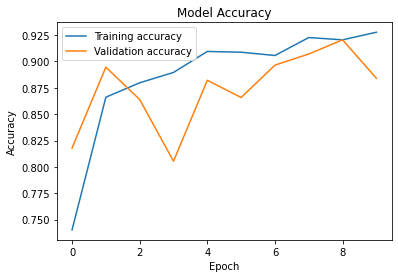

In [43]:
# Plot accuracy 
mpt.plot(history_resnet.history['accuracy'])
mpt.plot(history_resnet.history['val_accuracy'])
mpt.title('Model Accuracy')
mpt.ylabel('Accuracy')
mpt.xlabel('Epoch')
mpt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
mpt.show()

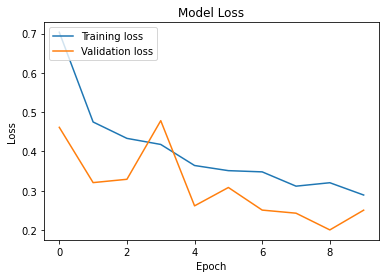

In [44]:
# Plot loss 
mpt.plot(history_resnet.history['loss'])
mpt.plot(history_resnet.history['val_loss'])
mpt.title('Model Loss')
mpt.ylabel('Loss')
mpt.xlabel('Epoch')
mpt.legend(['Training loss', 'Validation loss'], loc='upper left')
mpt.show()

In [45]:
# Predict
y_predict_resnet = model_2.predict(x_test)

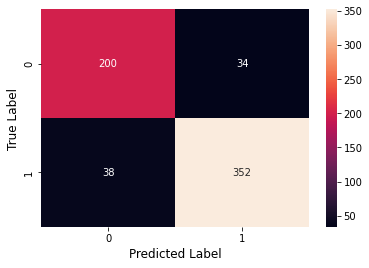

In [46]:
# Plot heatmap
pred_labels_resnet= np.where(y_predict_resnet>0.5, 1, 0)
sns.heatmap(confusion_matrix(y_test, pred_labels_resnet),fmt='g', annot=True)
mpt.xlabel("Predicted Label", fontsize= 12)
mpt.ylabel("True Label", fontsize= 12)

mpt.show()

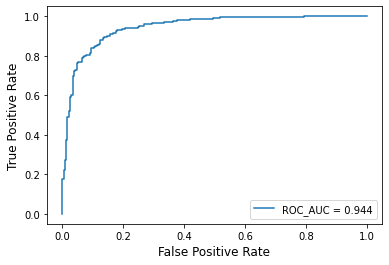

In [47]:
# Plot ROC curve
roc_auc = roc_auc_score(y_test, y_predict_resnet)

fpr, tpr, thresholds = roc_curve(y_test, y_predict_resnet)

mpt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

mpt.xlabel("False Positive Rate", fontsize= 12)
mpt.ylabel("True Positive Rate", fontsize= 12)
mpt.legend(loc="lower right")

mpt.show()

In [48]:
print(classification_report(y_test, pred_labels_resnet, target_names=test_set.class_indices.keys()))

              precision    recall  f1-score   support

      NORMAL       0.84      0.85      0.85       234
   PNEUMONIA       0.91      0.90      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.88      0.88       624



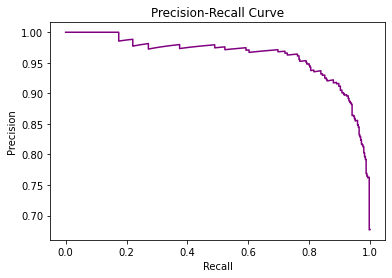

In [49]:
# Plot Precision-Recall curve



#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_predict_resnet)

#create precision recall curve
fig, ax = mpt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
mpt.show()



In [51]:
x = shap.GradientExplainer(model_2, x_test)
shap_values = x.shap_values(x_test[:100])
ind_names = list(map(str, y_test))
for i in range(len(ind_names)):
  if ind_names[i] == "0.0" :
    ind_names[i] = 'Normal'
  elif ind_names[i] == "1.0" :
    ind_names[i] = 'Pneumonia'
    
shap.image_plot(shap_values[0][:50], x_test[:50], true_labels = ind_names[:50], labels = pred_labels_resnet[:50])

StagingError: in user code:

    /opt/conda/lib/python3.7/site-packages/shap/explainers/_gradient.py:214 grad_graph  *
        x_grad = tape.gradient(out, x)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/backprop.py:1090 gradient  **
        unconnected_gradients=unconnected_gradients)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/imperative_grad.py:77 imperative_grad
        compat.as_str(unconnected_gradients.value))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/backprop.py:148 _gradient_function
        grad_fn = ops._gradient_registry.lookup(op_name)  # pylint: disable=protected-access
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/registry.py:100 lookup
        "%s registry has no entry for: %s" % (self._name, name))

    LookupError: gradient registry has no entry for: shap_StridedSlice
